## AP (Average Precision) の計算方法を確認する

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
coord_cols = ["ymin","xmin","ymax","xmax"]

### Numpy関数の動作確認

In [2]:
# np.prodの動作確認
print(np.prod((2,3.5)), "\n") #tuple内の数値を掛け算する
print(np.prod((3,5)), "\n")

# np.maximumの動作確認
a = np.array([2, 3, 4])
b = np.array([1, 5, 2])
c = np.array([[1, 5, 2],[3, 6, 0]])
d = np.array([[2, 0, 3],[1, 5, 1],[1, 0, 7]])
print(np.maximum(a,b), "\n")
print(np.maximum(a,c), "\n")
print(c.shape, c[:,None,:].shape, "\n")
print(np.maximum(c[:,None,:], d), "\n") # 全ての組み合わせ(ここでは6パターン)のmaximumを計算できる

# np.argsortの動作確認
score = np.array([0.9, 0.4, 0.35, 0.6])
print(np.argsort(score)[::-1], "\n") # 降順のインデックスを返す

# np.whereの動作確認
selec = np.array([True, False,True])
print(np.where(selec)[0], "\n") # Trueのインデックスを返す

# np.nan_to_numの動作確認
print(np.nan_to_num([np.nan, 1, 5, np.nan]), "\n") # nanを0に置き換える

7.0 

15 

[2 5 4] 

[[2 5 4]
 [3 6 4]] 

(2, 3) (2, 1, 3) 

[[[2 5 3]
  [1 5 2]
  [1 5 7]]

 [[3 6 3]
  [3 6 1]
  [3 6 7]]] 

[0 3 1 2] 

[0 2] 

[0. 1. 5. 0.] 



### バウンディングボックスを可視化するための関数

In [3]:
def viz(df_bbox_a, df_bbox_b, title=None):
    """
    バウンディングボックスを可視化するための関数
    """    
    plt.figure(figsize=(5.3,4.9))
    
    for i in range(2):
        if i==0:
            df = df_bbox_a
            clr = "red"
        elif i==1:
            df = df_bbox_b
            clr = "green"
            
        for ind, rows in df.iterrows():
            rec = plt.Rectangle(xy=[rows["xmin"], rows["ymin"]],
                                              width=rows["xmax"]-rows["xmin"],
                                              height=rows["ymax"]-rows["ymin"],
                                              fill=False, edgecolor=clr, linestyle="--") 
            plt.gca().add_patch(rec)

    plt.ylim([0,5])
    plt.xlim([0,5])
    plt.ylabel("y")
    plt.xlabel("x")
    plt.title(title)
    plt.show()

### 動作確認用データの用意 その1

,ymin,xmin,ymax,xmax,score
bbox_pred1,1.00,1.00,2.00,2.00,0.90
bbox_pred2,2.00,2.00,3.00,3.00,0.40
bbox_pred3,2.10,2.10,3.10,3.10,0.35
bbox_pred4,2.25,1.25,2.75,1.75,0.60
bbox_pred5,1.40,0.40,2.40,1.40,0.95


,ymin,xmin,ymax,xmax
bbox_gt1,1.5,0.5,2.5,1.5
bbox_gt2,1.0,3.5,2.0,4.5


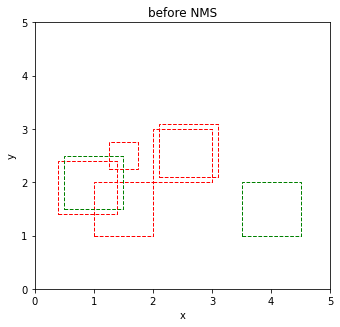

In [4]:
# 検出されたバウンディングボックス
df_bbox_pred = pd.DataFrame({"bbox_pred1":[1,1,2,2],
                                                        "bbox_pred2": [2,2,3,3],
                                                        "bbox_pred3": [2.1,2.1,3.1,3.1],
                                                        "bbox_pred4": [2.25,1.25,2.75,1.75],
                                                        "bbox_pred5":[1.4,0.4,2.4,1.4]
                                                      }, index=coord_cols).T
# 信頼度の設定
df_bbox_pred["score"] =  [0.9, 0.4, 0.35, 0.6, 0.95]


# 正解のバウンディングボックス(gtはground truthの略)
df_bbox_gt = pd.DataFrame({"bbox_gt1":[1.5,0.5,2.5,1.5],
                                                      "bbox_gt2": [1,3.5,2,4.5]
                                                    }, index=coord_cols).T
display(df_bbox_pred)
display(df_bbox_gt)

# バウンディングボックスの可視化
viz(df_bbox_pred, df_bbox_gt, title="before NMS")

### IoU (Intersection over Union) を計算する関数

In [5]:
def bbox_iou(bbox_a, bbox_b):
    """
    IoU (Intersection over Union) を計算する関数
    bbox_a : ndarray, バウンディングボックスa, bbox_a.shape = (バウンディングボックスの数, 4)
    bbox_b : ndarray, バウンディングボックスb, bbox_b.shape = (バウンディングボックスの数, 4)
                                    第1次元の4は、["ymin","xmin","ymax","xmax"]の4座標 
    """

    # 重なる部分の面積を求める
    # [:, None, :2]のNoneでは、bbox_aとbbox_bの全組み合わせを計算するために軸を増やしている
    bl = np.maximum(bbox_a[:, None, :2], bbox_b[:, :2]) # 重なる部分の左下の座標
    tr = np.minimum(bbox_a[:, None, 2:], bbox_b[:, 2:]) # 重なる部分の右上の座標
    area_i = np.prod(tr - bl, axis=2) * (bl < tr).all(axis=2) # (bl < tr).all(axis=2)は、2つのバウンディングボックスが重なっているかどうかを判定している
    
    # バウンディングボックスaの面積を求める
    area_a = np.prod(bbox_a[:, 2:] - bbox_a[:, :2], axis=1)
    
    # バウンディングボックスbの面積を求める
    area_b = np.prod(bbox_b[:, 2:] - bbox_b[:, :2], axis=1)
    
    # IoUを計算し、return
    iou = area_i / (area_a[:, None] + area_b - area_i)+.0 # +.0は-0.0を0.0にするために付けている
    return iou

### IoUの算出

In [6]:
# IoUの算出
IoU = bbox_iou(df_bbox_pred[coord_cols].values, df_bbox_gt.values)
df_IoU = pd.DataFrame(IoU, index=df_bbox_pred.index, columns=df_bbox_gt.index)
df_IoU.round(2)

,bbox_gt1,bbox_gt2
bbox_pred1,0.14,0.0
bbox_pred2,0.00,0.0
bbox_pred3,0.00,0.0
bbox_pred4,0.05,0.0
bbox_pred5,0.68,0.0


### NMS (Non-Maximum Suppresion) を計算する関数

In [7]:
def nms_index(bbox, score, iou_thresh):
    """
    NMS (Non-Maximum Suppresion) を計算する関数
    bbox : ndarray, バウンディングボックス, bbox.shape = (バウンディングボックスの数, 4)
                第1次元の4は、["ymin","xmin","ymax","xmax"]の4座標 
    score : ndarray, 信頼度 
    iou_thresh : float, IoUの閾値
    """
    
    # scoreを降順に並べる時のインデックスを取得する
    order = np.argsort(score)[::-1]
    
    # bboxを降順に並べる
    bbox = bbox[order]

    # 面積を算出する
    bbox_area = np.prod(bbox[:, 2:] - bbox[:, :2], axis=1)
    
    # バウンディングボックスの数と同じ要素数を持ったFalse配列selecを作る
    # このselecに各バウンディングボックスの採用、不採用を格納する
    selec = np.zeros(bbox.shape[0], dtype=bool)
    
    # バウンディングボックスをループ
    for i in range(bbox.shape[0]):        
        
        # 対象のバウンディングボックスbと、すでに採用が決まっているバウンディングボックスbboxとを比較し、重なる部分の面積を求める
        b = bbox[i:i+1, :]
        iou = bbox_iou(b, bbox[selec,:]) # <- selecで対象を絞っていることに注意!! selecが全てFalseの場合、iouは空配列になる
        
        if (iou >= iou_thresh).any():            
            """
            対象のバウンディングボックスbとのIoUがthresh以上になるものが1つでもあれば、
            そのバウンディングボックスbは採用しないので、selec[i]はFalseのまま
            """
            pass
        else:       
            """
            対象のバウンディングボックスbとのIoUがthresh以上になるものが1つもなければ、
            そのバウンディングボックスbを採用するので、selec[i]をTrueにする
            (iouが空配列の場合もこちらになる)
            """
            selec[i] = True


    # 配列selecにおけるTrueのインデックスを取得する
    selec = np.where(selec)[0]
    
    # 降順に並び替える前のインデックスになおす
    selec = order[selec]
    
    return selec

## 検出されたバウンディングボックスについて、NMSを実行し、重なりが大きいバウンディングボックスを排除する

,ymin,xmin,ymax,xmax,score
bbox_pred5,1.40,0.40,2.40,1.40,0.95
bbox_pred1,1.00,1.00,2.00,2.00,0.90
bbox_pred4,2.25,1.25,2.75,1.75,0.60
bbox_pred2,2.00,2.00,3.00,3.00,0.40


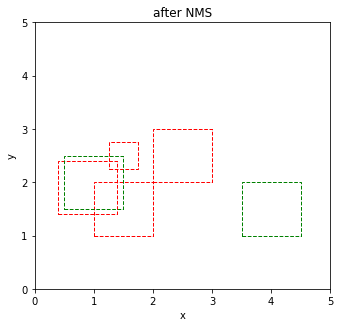

In [8]:
# NMSの実行
selected_index = nms_index(df_bbox_pred[coord_cols].values,
                                                   score=df_bbox_pred["score"].values, iou_thresh=0.5)
df_bbox_nms = df_bbox_pred.iloc[selected_index, :]
# score_nms = score[selected_index]
display(df_bbox_nms)

# バウンディングボックスの可視化
viz(df_bbox_nms, df_bbox_gt, title="after NMS")

### 動作確認用データの用意 その2


***************** picture1 *****************


,ymin,xmin,ymax,xmax,score
bbox_pred1,1.00,1.00,2.00,2.00,0.90
bbox_pred2,2.00,2.00,3.00,3.00,0.40
bbox_pred3,1.10,3.50,2.10,4.60,0.95
bbox_pred4,2.25,1.25,2.75,1.75,0.70
bbox_pred5,1.40,0.40,2.40,1.40,0.95


,ymin,xmin,ymax,xmax
bbox_gt1,1.5,0.5,2.5,1.5
bbox_gt2,1.0,3.5,2.0,4.5




***************** picture2 *****************


,ymin,xmin,ymax,xmax,score
bbox_pred1,1.00,1.00,2.00,2.00,0.90
bbox_pred2,2.90,3.50,3.90,4.90,0.80
bbox_pred3,3.60,3.10,4.60,4.10,0.85
bbox_pred4,2.25,1.25,2.75,1.75,0.60
bbox_pred5,1.40,1.40,2.40,2.40,0.95


,ymin,xmin,ymax,xmax
bbox_gt1,1.5,1.5,2.5,2.5
bbox_gt2,3.0,3.5,4.0,4.5




***************** picture3 *****************


,ymin,xmin,ymax,xmax,score
bbox_pred1,1.00,1.00,2.00,2.00,0.70
bbox_pred2,2.00,2.00,3.00,3.00,0.40
bbox_pred3,2.10,2.10,3.10,3.10,0.35
bbox_pred4,2.25,4.25,2.75,4.75,0.55
bbox_pred5,1.40,0.40,2.40,1.40,0.80


,ymin,xmin,ymax,xmax
bbox_gt1,1.5,0.5,2.5,1.5
bbox_gt2,1.0,3.5,2.0,4.5



******************** NMS前 ********************


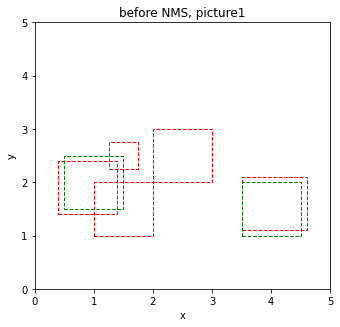

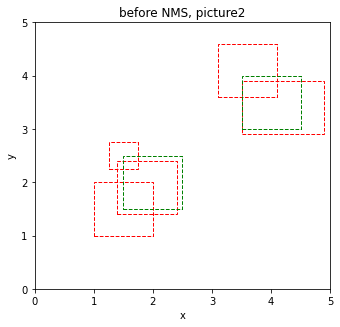

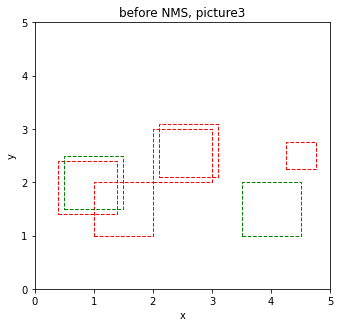

******************** NMS後 ********************


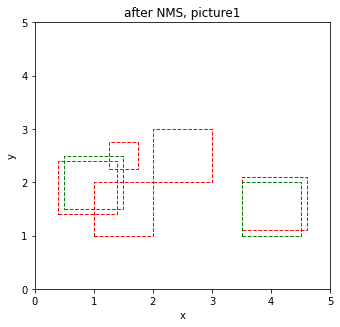

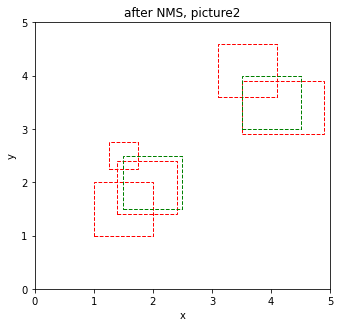

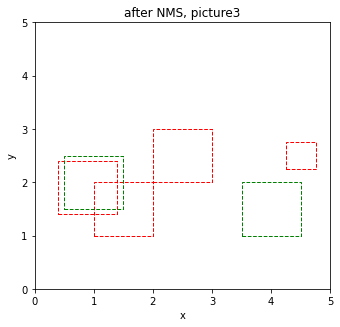

In [9]:
# 検出されたバウンディングボックス
dic_bbox_pred = {}
df = pd.DataFrame({"bbox_pred1":[1,1,2,2],
                                  "bbox_pred2": [2,2,3,3],
                                  "bbox_pred3":  [1.1,3.5,2.1,4.6],
                                  "bbox_pred4": [2.25,1.25,2.75,1.75],
                                 "bbox_pred5":[1.4,0.4,2.4,1.4]
                                 }, index=coord_cols).T
df["score"] = [0.9, 0.4, 0.95, 0.70, 0.95]
dic_bbox_pred["picture1"] = df

df = pd.DataFrame({"bbox_pred1":[1,1,2,2],
                                  "bbox_pred2": [2.9,3.5,3.9,4.9],
                                  "bbox_pred3": [3.6,3.1,4.6,4.1],
                                  "bbox_pred4": [2.25,1.25,2.75,1.75],
                                 "bbox_pred5":[1.4,1.4,2.4,2.4]
                                 }, index=coord_cols).T
df["score"] = [0.9, 0.8, 0.85, 0.6, 0.95]
dic_bbox_pred["picture2"] = df

df = pd.DataFrame({"bbox_pred1":[1,1,2,2],
                                  "bbox_pred2": [2,2,3,3],
                                  "bbox_pred3": [2.1,2.1,3.1,3.1],
                                  "bbox_pred4": [2.25,4.25,2.75,4.75],
                                 "bbox_pred5":[1.4,0.4,2.4,1.4]
                                 }, index=coord_cols).T
df["score"] = [0.7, 0.4, 0.35, 0.55, 0.80]
dic_bbox_pred["picture3"] = df


# 正解のバウンディングボックス
dic_bbox_gt = {}
df = pd.DataFrame({"bbox_gt1":[1.5,0.5,2.5,1.5],
                                    "bbox_gt2": [1,3.5,2,4.5]
                                    }, index=coord_cols).T
dic_bbox_gt["picture1"] = df

df = pd.DataFrame({"bbox_gt1":[1.5,1.5,2.5,2.5],
                                    "bbox_gt2": [3,3.5,4,4.5]
                                    }, index=coord_cols).T
dic_bbox_gt["picture2"] = df

df = pd.DataFrame({"bbox_gt1":[1.5,0.5,2.5,1.5],
                                    "bbox_gt2": [1,3.5,2,4.5]
                                    }, index=coord_cols).T
dic_bbox_gt["picture3"] = df

for key in dic_bbox_pred.keys():
    print()
    print("*"*17, key, "*"*17)
    df_bbox_pred = dic_bbox_pred[key]
    df_bbox_gt = dic_bbox_gt[key]
    display(df_bbox_pred)
    display(df_bbox_gt)
    print()
    
    
# バウンディングボックスの可視化
print("*"*20, "NMS前", "*"*20)
for key in dic_bbox_pred.keys():
    df_bbox_pred = dic_bbox_pred[key]
    df_bbox_gt = dic_bbox_gt[key]
    viz(df_bbox_pred, df_bbox_gt, title="before NMS, %s"%key)


# NMSの実行
dic_bbox_nms = {}
dic_score_nms = {}
for key in dic_bbox_pred.keys():
    df_bbox_pred = dic_bbox_pred[key]
    bbox = df_bbox_pred[coord_cols].values
    score = df_bbox_pred["score"].values
    selected_index = nms_index(bbox, score, iou_thresh=0.5)
    df_bbox_nms = df_bbox_pred.iloc[selected_index, :]
    score_nms = score[selected_index]
    dic_bbox_nms[key] = df_bbox_nms
    dic_score_nms[key] = score_nms
    

# バウンディングボックスの可視化
print("*"*20, "NMS後", "*"*20)
for key in dic_bbox_pred.keys():
    df_bbox_nms = dic_bbox_nms[key]
    df_bbox_gt = dic_bbox_gt[key]
    viz(df_bbox_nms, df_bbox_gt, title="after NMS, %s"%key)

### APを算出する関数

In [10]:
def rec_prec(dic_bbox_pred, dic_bbox_gt, dic_score, iou_thresh):
    """
    ある1つのクラスについて、RecallとPrecisionを計算する関数
    dic_bbox_pred : dict, keyは画像名, valueは検出されたバウンディングボックス
    dic_bbox_gt     : dict, keyは画像名, valueは正解のバウンディングボックス
    dic_score : dict, keyは画像名, valueは信頼度を格納したndarray 
    iou_thresh : float, IoUの閾値
    """
    
    # 対応する正解バウンディングボックスの有無を格納するリスト
    matches = []
    
    # スコアを格納するリスト
    scores = []
    
    # 正解バウンディングボックス数を格納する変数
    n_pos = 0
    
    for key in dic_bbox_pred.keys():
        """
        画像のループ
        """
        bbox_pred = dic_bbox_pred[key][coord_cols].values
        bbox_gt = dic_bbox_gt[key].values
        score = dic_score[key]

        # scoreを降順に並べる時のインデックスを取得する
        order = np.argsort(score)[::-1]

        # bboxを降順に並べる
        bbox_pred = bbox_pred[order]

        # スコアを降順に並べる
        score = score[order]    
        
        # スコアをリストに追加する
        scores.extend(score)
        
        # 正解バウンディングボックスの数をn_posに加える
        n_pos += bbox_gt.shape[0]
        
        # IoUを算出
        iou = bbox_iou(bbox_pred, bbox_gt)

        # 各検出バウンディングボックスについて、最もIoUが大きくなる正解バウンディングボックスのインデックスを取得する
        gt_index = iou.argmax(axis=1)

        # もし、IoUが閾値以上になる正解バウンディングボックスが存在しなければ、-1を割り当てる
        gt_index[iou.max(axis=1) < iou_thresh] = -1

        # 正解バウンディングボックスの数と同じ要素数を持ったFalse配列selectedを作る
        # このselectedに各正解バウンディングボックスの対応済みor未対応を格納していく
        selected = np.zeros(bbox_gt.shape[0], dtype=bool) # Falseは未対応を意味する

        # 検出バウンディングボックスのループ
        for idx in gt_index:
            """
            検出バウンディングボックスをスコア降順でみていく
            idxは、対象となる検出バウンディングボックスと最もIoUが大きくなる正解バウンディングボックスのindex
            """
            if idx >= 0:
                """
                この検出バウンディングボックスに正解バウンディングボックスのインデックスが割り当てられている場合
                """
                if not selected[idx]:
                    """
                    正解バウンディングボックスidxが未対応の場合
                    """
                    matches.append(1) # 対応する正解バウンディングボックスあり
                else:   
                    matches.append(0) # 対応する正解バウンディングボックスなし
                    
                # 正解バウンディングボックスidxを対応済みにする
                selected[idx] = True                    
            else:
                """
                この検出バウンディングボックスに正解バウンディングボックスのインデックスが割り当てられていない場合
                """                
                matches.append(0) # 対応する正解バウンディングボックスなし
    

    # ndarray型に変換する
    scores = np.array(scores)
    matches = np.array(matches)

    # 全画像を対象として、スコアの降順にならべかえる
    order = scores.argsort()[::-1]
    matches = matches[order]

    # 全画像を対象として、累積値を計算する
    tp = np.cumsum(matches == 1) # TruePositiveの累積値
    fp = np.cumsum(matches == 0) # FalsePositiveの累積値
    
    # Precisionを計算する
    prec = tp / (fp + tp)

    # Recallを計算する
    if n_pos > 0:
        rec = tp / n_pos
        
    return rec, prec


def ap_oneclass(dic_bbox_pred, dic_bbox_gt, dic_score, iou_thresh):
    """
    ある1つのクラスについて、APを計算する関数
    dic_bbox_pred : dict, keyは画像名, valueは検出されたバウンディングボックス
    dic_bbox_gt     : dict, keyは画像名, valueは正解のバウンディングボックス
    dic_score : dict, keyは画像名, valueは信頼度を格納したndarray 
    iou_thresh : float, IoUの閾値        
    """
    
    # RecallとPrecisionを求める
    rec, prec = rec_prec(dic_bbox_pred, dic_bbox_gt, dic_score, iou_thresh)
    
    if rec is None or prec is None:
        ap = np.nan
        return ap

    # VOC2007の計算方法でAPを算出する
    ap = 0
    int_prec = [] # 補間されたprecision
    for t in np.arange(0., 1.1, 0.1):
        if np.sum(rec >= t) == 0:
            """
            t以上のRecallが存在しないとき(つまり、検出されなかった正解バウンディングボックスがある場合)
            """
            p = 0
        else:
            p = np.max(np.nan_to_num(prec)[rec >= t]) # Recallがt以上になるPrecisionのうち、最大のものをpとする
        ap += p / 11
        int_prec.append(p)
    int_prec = np.array(int_prec)
    
    return rec, prec, int_prec, ap

### APの算出

In [11]:
rec, prec, int_prec, ap = ap_oneclass(dic_bbox_nms, dic_bbox_gt, dic_score=dic_score_nms, iou_thresh=0.5)
print("Recall : \n", rec.round(2), "\n")
print("Precision : \n", prec.round(2), "\n")
print("Interpolated Precision : \n", int_prec.round(2), "\n")
print("Average Precision : ", round(ap,3), "\n")

Recall : 
 [0.17 0.33 0.5  0.5  0.5  0.5  0.67 0.83 0.83 0.83 0.83 0.83 0.83 0.83] 

Precision : 
 [1.   1.   1.   0.75 0.6  0.5  0.57 0.62 0.56 0.5  0.45 0.42 0.38 0.36] 

Interpolated Precision : 
 [1.   1.   1.   1.   1.   1.   0.62 0.62 0.62 0.   0.  ] 

Average Precision :  0.716 



### PR曲線の描画

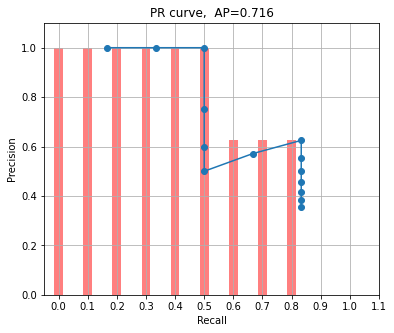

In [12]:
# RecallとPrecisionを描画
plt.figure(figsize=(6,5))
plt.plot(rec, prec, marker="o")
plt.ylim([0,1.1])
plt.xlim([-0.05,1.1])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("PR curve,  AP=%0.3f"%ap)
plt.grid()
plt.xticks(np.linspace(0, 1.1, 12))

# 補間されたPrecisionを描画
# APは、赤棒の長さの平均値である。
plt.bar(np.arange(0., 1.1, 0.1), int_prec, width=0.03, alpha=0.5, color="r")

plt.show()